In [9]:
import matplotlib
from matplotlib import colors
from scipy import stats
from ipywidgets import HBox, VBox
from scipy import signal
from scipy.io import loadmat
from weight_matrix_utils import normalize, generate_modulars
from neurolib.models.wc import WCModel
import sys
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import neurolib.utils.loadData as ld
from neurolib.utils import functions

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
matplotlib.rcParams['font.family'] = 'Avenir'
matplotlib.rcParams['font.size'] = 16
plt.rcParams['image.cmap'] = 'plasma'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_path = './papadopulusData/'

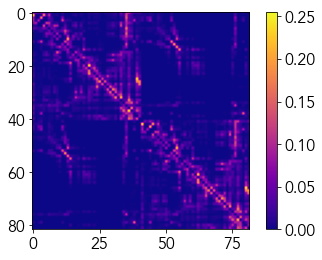

In [3]:
A = loadmat(data_path+'Aij_human_Streamlines_scale82.mat')['Aij']
A_norm = normalize(A, norm_type='cols')
plt.imshow(A_norm);plt.colorbar();

In [4]:
D = loadmat(data_path+'Dij_human_Streamlines_scale82.mat')['Dij']
np.max(D), np.mean(D)

(64.87498009160304, 28.185306051622604)

In [5]:
BOLD = True

In [6]:
def draw_whole_brain(duration = None, sigma_ou = None, K_gl = None, exc_ext = None):
    wc = WCModel(Cmat=A_norm, Dmat = D)
    if duration:
        wc.params['duration'] = duration*1000 
    else: 
        wc.params['duration'] = 60*1000 
    if exc_ext:
        wc.params['exc_ext'] = exc_ext #этот параметр подбираем
    else:    
        wc.params['exc_ext'] = 0.7 
    if sigma_ou:
        wc.params['sigma_ou'] = sigma_ou
    else:
        wc.params['sigma_ou'] = 2*1e-3 #best value 2*1e-2 for 300 regions
    if K_gl:
         wc.params['K_gl'] = K_gl
    else:
        wc.params['K_gl'] = 2.75 # и этот тоже
    
    wc.params['inh_ext'] = 0
    wc.params['tau_ou'] = 5
    wc.params['a_exc'] = 1.5
    wc.params['a_inh'] = 1.5 
    wc.params['mu_exc'] = 3
    wc.params['mu_inh'] = 3
    wc.params['tau_exc'] = 2.5
    wc.params['tau_inh'] = 3.75
    wc.params['signalV'] = 10
    wc.run(chunkwise=True, bold=BOLD)
    dt = wc.params['dt']
    fs =  1/dt*1e03
    spectrum = []
    series = [wc.exc.T[:,i] for i in range(wc.exc.T.shape[1])]
    
        
    #f, Pxx_den = signal.periodogram(wc.exc.T[:,i],fs)
    #f, Pxx_den = signal.welch(wc.exc.T[:,i] - np.mean(wc.exc.T[:,i]),fs)
    # spectrum.append(Pxx_den)
    maxfr = 100
    f, Pxx_Welsh =  functions.getMeanPowerSpectrum(series, dt, maxfr=maxfr)

    fig, axs = plt.subplots(2, 2, figsize = (8,6))
    axs[0,0].plot(wc.t, wc.exc.T[:,10])

    axs[0,0].set_xlabel("t [ms]")
    axs[0,0].set_ylabel("Activity")
    axs[0,0].set_title('ROIs excitation activity'); 
    axs[0,1].semilogy(f,  Pxx_Welsh)
    axs[0,1].set_xlim([0, maxfr])
    axs[0,1].set_xlabel('frequency [Hz]')
    axs[0,1].set_ylabel('PSD [V**2/Hz]')
    axs[0,1].set_title('Mean Power density for excitation activity'); 
    axs[1,0].imshow(np.corrcoef(wc.exc));
    axs[1,0].set_title('Neural correlation matrix '); 
    if wc.BOLD.BOLD.shape[1] > 10:
        axs[1,1].imshow(np.corrcoef(wc.BOLD.BOLD[:,10:]));
    axs[1,1].set_title('Bold correlation matrix '); 

    plt.tight_layout()
    plt.show()

In [7]:
#wc.params
K_gl = widgets.FloatSlider(value = 2.5, min = 0.5, max = 6, step = 0.25, description = r'K_gl', disabled=False)
exc_ext = widgets.FloatSlider(value = 0.7, min = 0.5, max = 0.85, step = 0.025, description = r'P_e', disabled=False)
sigma_ou = widgets.FloatSlider(value = 5*1e-05, min = 0, max = 0.02, step = 1e-05, description = r'$ \sigma_{OU} : $' , disabled=False,  readout_format='.1e')
duration = widgets.IntSlider(value = 4, min = 2, max = 60, step = 2, description = r'duration (s)')


In [8]:
row1 = HBox([exc_ext, K_gl])
row2 = HBox([sigma_ou, duration] )
ui = VBox( [row1, row2] )
out = widgets.interactive_output(draw_whole_brain, {'exc_ext': exc_ext,  'sigma_ou':sigma_ou, 'K_gl': K_gl, 'duration': duration} )
display(ui, out)

Output()

## Coupling vs Background drive

In [13]:
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import neurolib.optimize.exploration.explorationUtils as eu


In [14]:
wc = WCModel(Cmat=A_norm, Dmat = D)
wc.params['duration'] = 120*1000 
wc.params['exc_ext'] = 0.7 
wc.params['sigma_ou'] = 5*1e-5
wc.params['K_gl'] = 2.75 # и этот тоже
wc.params['inh_ext'] = 0
wc.params['tau_ou'] = 5
wc.params['a_exc'] = 1.5
wc.params['a_inh'] = 1.5 
wc.params['mu_exc'] = 3
wc.params['mu_inh'] = 3
wc.params['tau_exc'] = 2.5
wc.params['tau_inh'] = 3.75
wc.params['signalV'] = 10

In [15]:
#np.linspace(1,3, 20)
#np.linspace(0.5,0.7, 15)

In [20]:
np.linspace(0.5,0.7, 15)

array([0.5       , 0.51428571, 0.52857143, 0.54285714, 0.55714286,
       0.57142857, 0.58571429, 0.6       , 0.61428571, 0.62857143,
       0.64285714, 0.65714286, 0.67142857, 0.68571429, 0.7       ])

In [17]:
# сделать меньше бокс: 0.
#parameters = ParameterSpace({"K_gl": np.linspace(0.5,3, 18), "exc_ext": np.linspace(0.5,0.85, 11)})


In [21]:
parameters = ParameterSpace({"K_gl": np.linspace(1.5,3, 15), "exc_ext": np.linspace(0.5,0.7, 15)})
# info: chose np.linspace(0, 3, 21) or more, values here are low for testing
search = BoxSearch(wc, parameters, filename="papadopulos_Bold_small_range.hdf")

MainProcess root INFO     Number of processes: 16
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/papadopulos_Bold_small_range.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 225
MainProcess root INFO     BoxSearch: Environment initialized.


In [22]:
%%time
search.run(chunkwise=True, bold=True)

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-05-06-19H-22M-45S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-05-06-19H-22M-45S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-05-06-19H-22M-45S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-05-06-19H-22M-45S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

CPU times: user 1min, sys: 15 s, total: 1min 15s
Wall time: 17min 51s


In [23]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/papadopulos_Bold_small_range.hdf
MainProcess root INFO     Analyzing trajectory results-2022-05-06-19H-22M-45S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/papadopulos_Bold_small_range.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-05-06-19H-22M-45S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|█████████████████████████████████████████| 225/225 [00:22<00:00,  9.91it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%

In [44]:
res_df = search.dfResults[['K_gl', 'exc_ext']].copy()
res_df.loc[:,'mean_exc'] = 0
res_df.loc[:,'std_exc'] = 0
res_df.loc[:,'max_freq'] = 0

In [118]:
%%time
dt = 0.1
maxfr = 100
for i in res_df.index:
    exc = search.dfResults.loc[i,'exc'].copy()
    res_df.loc[i,'std_exc'] = exc.std(axis=1).mean()
    res_df.loc[i,'mean_exc'] = exc.mean(axis=1).mean()
    series = [exc.T[:,i] for i in range(exc.T.shape[1])]
    f, Pxx_Welsh =  functions.getMeanPowerSpectrum(series, dt, maxfr=maxfr)
    res_df.loc[i,'max_freq'] = f[np.argmax(Pxx_Welsh)]

CPU times: user 16.7 s, sys: 2.44 s, total: 19.1 s
Wall time: 19.2 s


In [119]:
eu.findCloseResults(res_df, K_gl=[2.45, 2.55], exc_ext = [0.5, 0.6])

,K_gl,exc_ext,mean_exc,std_exc,max_freq,rho_loc,rho_gl,rho_loc_BOLD,rho_gl_BOLD,sp_r_BOLD,sp_r_pval,sp_pval,sp_r
136,2.464286,0.514286,0.061134,0.000284,20,0,0,0,0,0,0,0,0
137,2.464286,0.528571,0.071317,0.000370,27,0,0,0,0,0,0,0,0
138,2.464286,0.542857,0.082133,0.000819,22,0,0,0,0,0,0,0,0
139,2.464286,0.557143,0.080221,0.033331,26,0,0,0,0,0,0,0,0
140,2.464286,0.571429,0.080034,0.044883,28,0,0,0,0,0,0,0,0
141,2.464286,0.585714,0.080771,0.052881,30,0,0,0,0,0,0,0,0


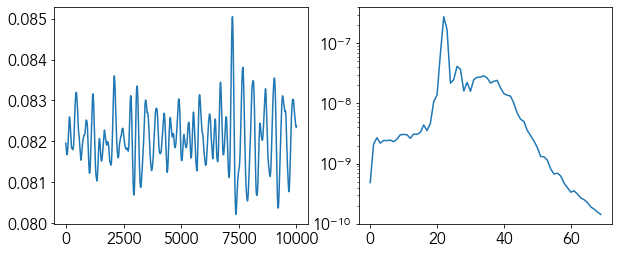

In [120]:
maxfr = 70
idx_df = 138
plt.figure(figsize = (10,4))
series = [search.dfResults.loc[idx_df,'exc'].T[:,i] for i in range(search.dfResults.loc[idx_df,'exc'].T.shape[1])]
plt.subplot(121); plt.plot(search.dfResults.loc[idx_df,'exc'][10,:10000])
#plt.plot(signal.resample(search.dfResults.loc[idx_df,'exc'][10,:10000],1000));
f, Pxx_Welsh =  functions.getMeanPowerSpectrum(series, dt, maxfr=maxfr)
plt.subplot(122); plt.semilogy(f,  Pxx_Welsh);

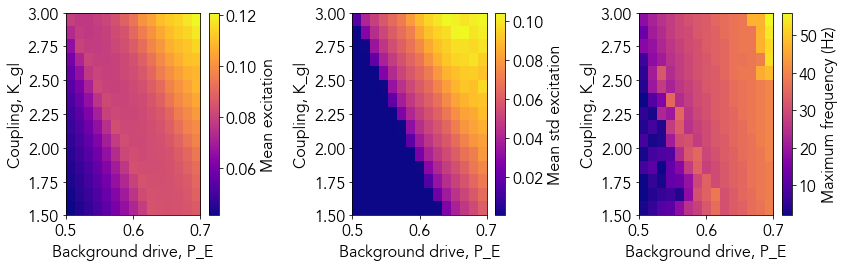

In [121]:
fig, axs = plt.subplots(1, 3, figsize = (12,4))

values_list = ['mean_exc', 'std_exc', 'max_freq']
labels_list = ['Mean excitation', 'Mean std excitation', 'Maximum frequency (Hz)']
for k in range(3):
    im = axs[k].imshow(res_df.pivot_table(values=values_list[k], index = 'K_gl', columns='exc_ext'),\
                        extent = [min(res_df.exc_ext), max(res_df.exc_ext),
                     min(res_df.K_gl), max(res_df.K_gl)], origin='lower', aspect='auto'); #norm=colors.LogNorm()
    fig.colorbar(im, label=labels_list[k] , ax = axs[k]);
    axs[k].set_xlabel("Background drive, P_E");
    axs[k].set_ylabel("Coupling, K_gl");
    fig.tight_layout()

In [113]:
pivoted_std = res_df.pivot_table(values='std_exc', index = 'K_gl', columns='exc_ext')
pivoted_std 

exc_ext,0.500000,0.514286,0.528571,0.542857,0.557143,0.571429,0.585714,0.600000,0.614286,0.628571,0.642857,0.657143,0.671429,0.685714,0.700000
K_gl,,,,,,,,,,,,,,,
1.500000,0.000169,0.000182,0.000197,0.000219,0.000243,0.000273,0.000311,0.000362,0.000438,0.000703,0.027302,0.038972,0.047000,0.053587,0.060670
1.607143,0.000172,0.000187,0.000205,0.000228,0.000255,0.000289,0.000335,0.000395,0.000539,0.022513,0.036428,0.045293,0.051988,0.058677,0.064977
1.714286,0.000178,0.000195,0.000217,0.000239,0.000269,0.000309,0.000370,0.000477,0.015487,0.033489,0.043461,0.050633,0.056872,0.063780,0.070066
1.821429,0.000183,0.000202,0.000223,0.000252,0.000291,0.000339,0.000418,0.000785,0.029810,0.041228,0.049112,0.055477,0.062074,0.069564,0.074010
1.928571,0.000191,0.000209,0.000235,0.000266,0.000316,0.000377,0.000525,0.025003,0.038655,0.047411,0.054140,0.060011,0.067215,0.071608,0.079554
2.035714,0.000194,0.000217,0.000249,0.000288,0.000346,0.000449,0.017862,0.035594,0.045417,0.052719,0.058686,0.065349,0.072935,0.078661,0.081716
2.142857,0.000203,0.000230,0.000265,0.000314,0.000400,0.000946,0.031796,0.043315,0.051141,0.057340,0.063212,0.071058,0.078704,0.082205,0.085967
2.250000,0.000210,0.000241,0.000286,0.000357,0.000493,0.026744,0.040648,0.049178,0.056074,0.061966,0.068931,0.076676,0.082528,0.084457,0.089883
2.357143,0.000223,0.000262,0.000318,0.000418,0.019045,0.037411,0.047351,0.054654,0.060499,0.066550,0.075041,0.082511,0.086916,0.090266,0.091276


In [122]:
def find_PE(pivoted_std = None, indC = 0):
    C = pivoted_std.iloc[indC].name
    PE = pivoted_std.columns[np.argmax(pivoted_std.iloc[indC].diff())]
    return C, PE
find_PE(pivoted_std = pivoted_std, indC = 5)

(2.0357142857142856, 0.6)

## Correlation analysis

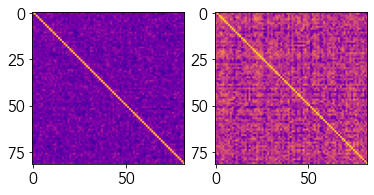

In [123]:
plt.subplot(121); plt.imshow(np.corrcoef(search.results[30]['exc']));
plt.subplot(122); plt.imshow(np.corrcoef(search.results[30]['BOLD'][:,10:]));

In [124]:
def compute_rhos(exc_matrix, A):
    rho  = np.corrcoef(exc)
    rho_global = np.mean(rho)
    rho_local = np.sum(A*rho)/np.sum(A)
    
    sp_r, sp_pval = stats.spearmanr(A_norm.flatten(), np.corrcoef(exc).flatten())
    return rho_global, rho_local, sp_r, sp_pval

In [126]:
res_df.loc[:,'rho_loc'] = 0
res_df.loc[:,'rho_gl'] = 0
res_df.loc[:,'rho_loc_BOLD']= 0
res_df.loc[:,'rho_gl_BOLD'] = 0
res_df.loc[:,'sp_r_BOLD'] = 0
res_df.loc[:,'sp_r_pval'] = 0
res_df.loc[:,'sp_pval'] = 0
res_df.loc[:,'sp_r'] = 0

In [127]:
%%time
for i in res_df.index:
    exc = search.dfResults.loc[i,'exc'].copy()
    BOLD =search.dfResults.loc[i,'BOLD'][:,10:].copy()
    res_df.loc[i,'rho_gl'], res_df.loc[i,'rho_loc'], res_df.loc[i,'sp_r'], res_df.loc[i,'sp_pval'] = compute_rhos(exc, A_norm)
    res_df.loc[i,'rho_gl_BOLD'], res_df.loc[i,'rho_loc_BOLD'], res_df.loc[i,'sp_r_BOLD'], res_df.loc[i,'sp_pval_BOLD'] = compute_rhos(BOLD, A_norm)


CPU times: user 34.1 s, sys: 5.06 s, total: 39.2 s
Wall time: 5.7 s


In [128]:
res_df.loc[:,'diff_rho'] = res_df.loc[:,'rho_loc']-res_df.loc[:,'rho_gl']
res_df.loc[:,'diff_rho_BOLD'] = res_df.loc[:,'rho_loc_BOLD']-res_df.loc[:,'rho_gl_BOLD']

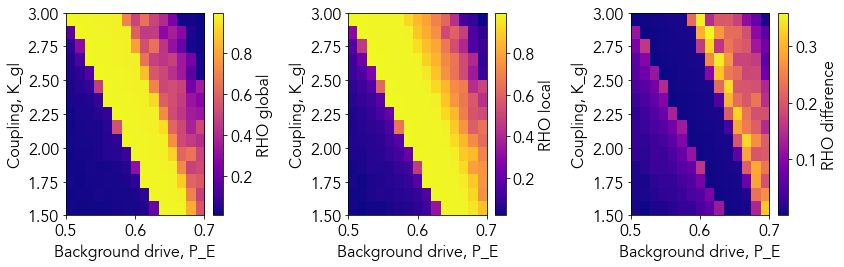

In [129]:
fig, axs = plt.subplots(1, 3, figsize = (12,4))

values_list = ['rho_gl', 'rho_loc', 'diff_rho']
labels_list = ['RHO global', 'RHO local', 'RHO difference']
for k in range(3):
    im = axs[k].imshow(res_df.pivot_table(values=values_list[k], index = 'K_gl', columns='exc_ext'),\
                        extent = [min(res_df.exc_ext), max(res_df.exc_ext),
                     min(res_df.K_gl), max(res_df.K_gl)], origin='lower', aspect='auto'); #norm=colors.LogNorm()
    fig.colorbar(im, label=labels_list[k] , ax = axs[k]);
    axs[k].set_xlabel("Background drive, P_E");
    axs[k].set_ylabel("Coupling, K_gl");
    fig.tight_layout()

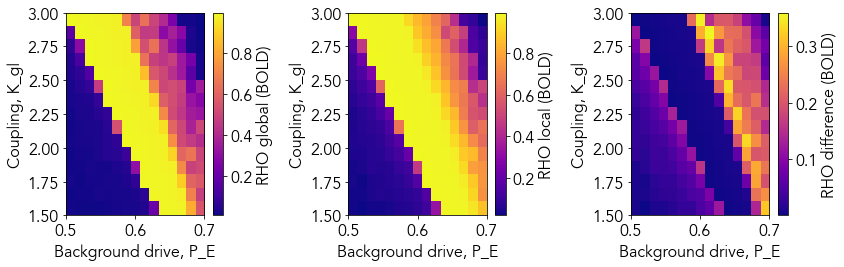

In [130]:
fig, axs = plt.subplots(1, 3, figsize = (12,4))

values_list = ['rho_gl_BOLD', 'rho_loc_BOLD', 'diff_rho_BOLD']
labels_list = ['RHO global (BOLD)', 'RHO local (BOLD)', 'RHO difference (BOLD)']
for k in range(3):
    im = axs[k].imshow(res_df.pivot_table(values=values_list[k], index = 'K_gl', columns='exc_ext'),\
                        extent = [min(res_df.exc_ext), max(res_df.exc_ext),
                     min(res_df.K_gl), max(res_df.K_gl)], origin='lower', aspect='auto'); #norm=colors.LogNorm()
    fig.colorbar(im, label=labels_list[k] , ax = axs[k]);
    axs[k].set_xlabel("Background drive, P_E");
    axs[k].set_ylabel("Coupling, K_gl");
    fig.tight_layout()

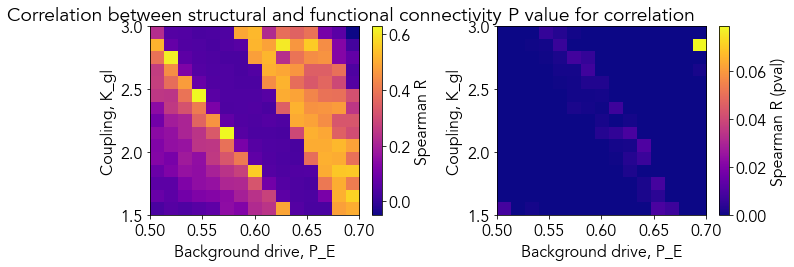

In [131]:
fig, axs = plt.subplots(1, 2, figsize = (10,4))

values_list = ['sp_r', 'sp_pval']
labels_list = ['Spearman R', 'Spearman R (pval)']
title_list = ['Correlation between structural and functional connectivity', 'P value for correlation']
for k in range(len(values_list)):
    im = axs[k].imshow(res_df.pivot_table(values=values_list[k], index = 'K_gl', columns='exc_ext'),\
                        extent = [min(res_df.exc_ext), max(res_df.exc_ext),
                     min(res_df.K_gl), max(res_df.K_gl)], origin='lower', aspect='auto'); #norm=colors.LogNorm()
    fig.colorbar(im, label=labels_list[k] , ax = axs[k]);
    axs[k].set_xlabel("Background drive, P_E");
    axs[k].set_ylabel("Coupling, K_gl");
    axs[k].set_title(title_list[k]);

    fig.tight_layout()

In [70]:
print(C_5, PE_5)

1.6764705882352942 0.64


In [132]:
indC = 6
def plot_values_for_bgr_drive(indC, value = 'rho_gl'):
    C, PE = find_PE(pivoted_std = pivoted_std, indC = indC)
    sp_r = res_df.pivot_table(values=value, index = 'K_gl', columns='exc_ext').iloc[indC].values
    PE_diff = res_df.pivot_table(values=value, index = 'K_gl', columns='exc_ext').iloc[indC].index-PE
    plt.plot(PE_diff, sp_r,'*-'); plt.xlabel('background drive'); plt.ylabel(value); 
    plt.title(f"Oscillatory for coupling {C: .2f} start from PE= {PE: .2f} ");

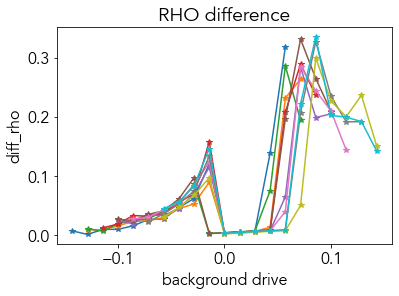

In [133]:
for i in range(10):
    plot_values_for_bgr_drive(i, value = 'diff_rho')
    plt.title('RHO difference')


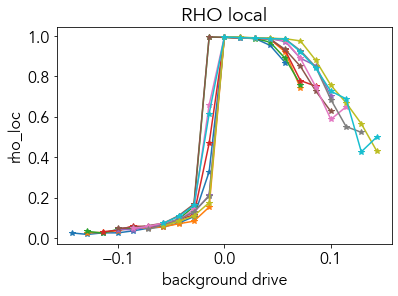

In [134]:
for i in range(10):
    plot_values_for_bgr_drive(i, value = 'rho_loc')
    plt.title('RHO local')

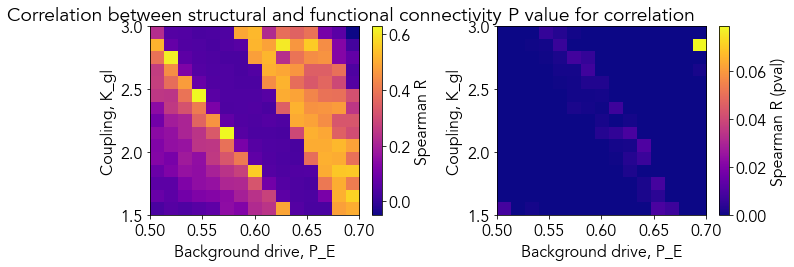

In [135]:
fig, axs = plt.subplots(1, 2, figsize = (10,4))

values_list = ['sp_r_BOLD', 'sp_pval_BOLD']
labels_list = ['Spearman R', 'Spearman R (pval)']
title_list = ['Correlation between structural and functional connectivity', 'P value for correlation']
for k in range(len(values_list)):
    im = axs[k].imshow(res_df.pivot_table(values=values_list[k], index = 'K_gl', columns='exc_ext'),\
                        extent = [min(res_df.exc_ext), max(res_df.exc_ext),
                     min(res_df.K_gl), max(res_df.K_gl)], origin='lower', aspect='auto'); #norm=colors.LogNorm()
    fig.colorbar(im, label=labels_list[k] , ax = axs[k]);
    axs[k].set_xlabel("Background drive, P_E");
    axs[k].set_ylabel("Coupling, K_gl");
    axs[k].set_title(title_list[k]);

    fig.tight_layout()

In [28]:
res_df.loc[res_df['sp_r']>0.5, ['K_gl', 'exc_ext', 'sp_r', 'sp_r_BOLD']]

,K_gl,exc_ext,sp_r,sp_r_BOLD
7,0.500000,0.745,0.519372,0.519372
39,1.205882,0.710,0.514825,0.514825
50,1.441176,0.710,0.551929,0.551929
79,2.147059,0.570,0.553986,0.553986
92,2.382353,0.640,0.512825,0.512825
110,2.852941,0.500,0.504818,0.504818
113,2.852941,0.605,0.520598,0.520598
134,3.323529,0.570,0.532920,0.532920
145,3.558824,0.570,0.544017,0.544017
155,3.794118,0.535,0.537090,0.537090


In [138]:
eu.findCloseResults(res_df, sp_r=[0.6,1])

,K_gl,exc_ext,mean_exc,std_exc,max_freq,rho_loc,rho_gl,rho_loc_BOLD,rho_gl_BOLD,sp_r_BOLD,sp_r_pval,sp_pval,sp_r,sp_pval_BOLD,diff_rho,diff_rho_BOLD
95,2.142857,0.571429,0.083363,0.000946,25,0.658526,0.534367,0.658526,0.534367,0.627440,0,0.0,0.627440,0.0,0.124158,0.124158
138,2.464286,0.542857,0.082133,0.000819,22,0.614561,0.468301,0.614561,0.468301,0.628612,0,0.0,0.628612,0.0,0.146260,0.146260
181,2.785714,0.514286,0.080108,0.000627,19,0.459527,0.297492,0.459527,0.297492,0.614917,0,0.0,0.614917,0.0,0.162035,0.162035
204,2.892857,0.628571,0.100579,0.095214,36,0.740162,0.467161,0.740162,0.467161,0.604747,0,0.0,0.604747,0.0,0.273000,0.273000


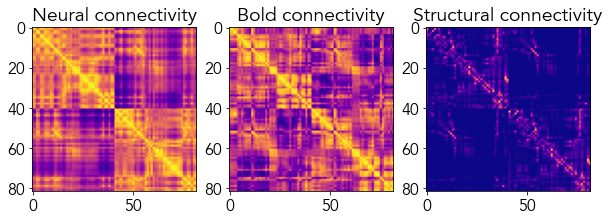

In [139]:
plt.figure(figsize = (10,6))
best_idx = 204
plt.subplot(131); plt.imshow(np.corrcoef(search.results[best_idx]['exc'])); plt.title('Neural connectivity');
plt.subplot(132); plt.imshow(np.corrcoef(search.results[best_idx]['BOLD'][:,10:])); plt.title('Bold connectivity');
plt.subplot(133); plt.imshow(A_norm); plt.title('Structural connectivity');

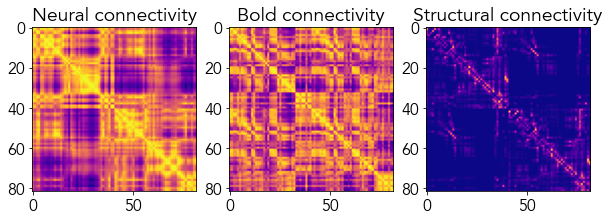

In [34]:
plt.figure(figsize = (10,6))
plt.subplot(131); plt.imshow(np.corrcoef(search.results[50]['exc'])); plt.title('Neural connectivity');
plt.subplot(132); plt.imshow(np.corrcoef(search.results[50]['BOLD'][:,10:])); plt.title('Bold connectivity');
plt.subplot(133); plt.imshow(A_norm); plt.title('Structural connectivity');

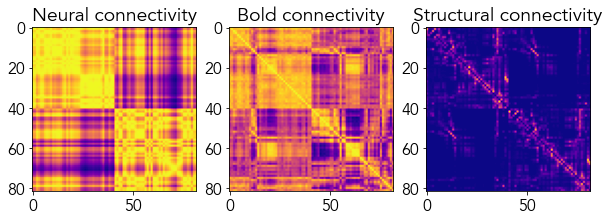

In [38]:
plt.figure(figsize = (10,6))
plt.subplot(131); plt.imshow(np.corrcoef(search.results[92]['exc'])); plt.title('Neural connectivity');
plt.subplot(132); plt.imshow(np.corrcoef(search.results[92]['BOLD'][:,10:])); plt.title('Bold connectivity');
plt.subplot(133); plt.imshow(A_norm); plt.title('Structural connectivity');